In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX

import math

# sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/nfshome/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list
     
import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/00
3.6.8 (default, Apr 25 2019, 21:02:35) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [2]:
dirs = {}

dirs['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-1d-prod/n3n2-n1-hbb-hbb/'
dirs['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-1d-prod/n3n2-n1-hbb-hbb/'
dirs['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-1d-prod/n3n2-n1-hbb-hbb/'
dirs['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-1d-prod/n3n2-n1-hbb-hbb/'

# dirs['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_m200_prompt_ev100000_signal_aod.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-2d-prod/x1n2-n1-wlv-hbb/'
# dirs['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl100_ev100000_signal_aod.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-2d-prod/x1n2-n1-wlv-hbb/'
# dirs['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl1000_ev100000_signal_aod.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-2d-prod/x1n2-n1-wlv-hbb/'
# dirs['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl10000_ev100000_signal_aod.root'] = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-2d-prod/x1n2-n1-wlv-hbb/'

dirs['2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root'] = '/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/SusyEwkHgg/Signal2016/TChiHH/'
# dirs['2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root'] = '/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/SusyEwkHgg/Signal2016/TChiWH/'

 
out_dir = '/nfshome/jmao/cms-llp/plots/20190916/'

fname = {
    'ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root',
    'ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root',
    'ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root',
    'ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root',
    
#     'ntuple_RunIISummer16_x1n2-n1-wlv-hbb_m200_prompt_ev100000_signal_aod.root',
#     'ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl100_ev100000_signal_aod.root',
#     'ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl1000_ev100000_signal_aod.root',
#     'ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl10000_ev100000_signal_aod.root',
    
    '2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root',
#     '2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root',
        }

texs = {}

texs['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root'] = 'prompt, H(bb)H(bb)'
texs['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root'] = 'ctau = 10 cm, H(bb)H(bb)'
texs['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root'] = 'ctau = 1 m, H(bb)H(bb)'
texs['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root'] = 'ctau = 10 m, H(bb)H(bb)'

# texs['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_m200_prompt_ev100000_signal_aod.root'] = 'prompt, W(lv)H(bb)'
# texs['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl100_ev100000_signal_aod.root'] = 'ctau = 10 cm, W(lv)H(bb)'
# texs['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl1000_ev100000_signal_aod.root'] = 'ctau = 1 m, W(lv)H(bb)'
# texs['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl10000_ev100000_signal_aod.root'] = 'ctau = 10 m, W(lv)H(bb)'

texs['2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root'] = 'cms, H(gg)H(gg)'
# texs['2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root'] = 'cms, W(lv)H(gg)'

cols = {}

cols['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root'] = 2
cols['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root'] = 3
cols['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root'] = 225
cols['ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root'] = 213

# cols['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_m200_prompt_ev100000_signal_aod.root'] = 4
# cols['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl100_ev100000_signal_aod.root'] = 6
# cols['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl1000_ev100000_signal_aod.root'] = 209
# cols['ntuple_RunIISummer16_x1n2-n1-wlv-hbb_mh200_pl10000_ev100000_signal_aod.root'] = 1

cols['2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root'] = 207
# cols['2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root'] = 51

tree = OrderedDict()

f_dir = ''
for file in fname:
    print(dirs[file]+file)
 
    root_dir = uproot.open(dirs[file]+file) 
    if 'ev' in file:
        tree[file] = root_dir['ntuples/llp']
    else:
        tree[file] = root_dir['HggRazorLeptons']
 
    print ('Open ready')
    print(texs[file])
    print ('Tree ready') 
    print(tree[file], tree)

/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/SusyEwkHgg/Signal2016/TChiHH/2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root
Open ready
cms, H(gg)H(gg)
Tree ready
<TTree b'HggRazorLeptons' at 0x7f953fb0a8d0> OrderedDict([('2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root', <TTree b'HggRazorLeptons' at 0x7f953fb0a8d0>)])
/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-1d-prod/n3n2-n1-hbb-hbb/ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root
Open ready
ctau = 1 m, H(bb)H(bb)
Tree ready
<TTree b'llp' at 0x7f953bad5780> OrderedDict([('2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root', <TTree b'HggRazorLeptons' at 0x7f953fb0a8d0>), ('ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root', <TTree b'llp' at 0x7f953bad5780>)])
/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/MSSM-1d-prod/n3n2-n1-hbb-hbb/ntuple_RunIISummer16_n3n2-n1-

# b jet Pt

ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7f696cfa76d8>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7f697ba624e0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7f696cfa7e10>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7f697bb36828>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f697ad9b0f0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/b_pt.png has been created


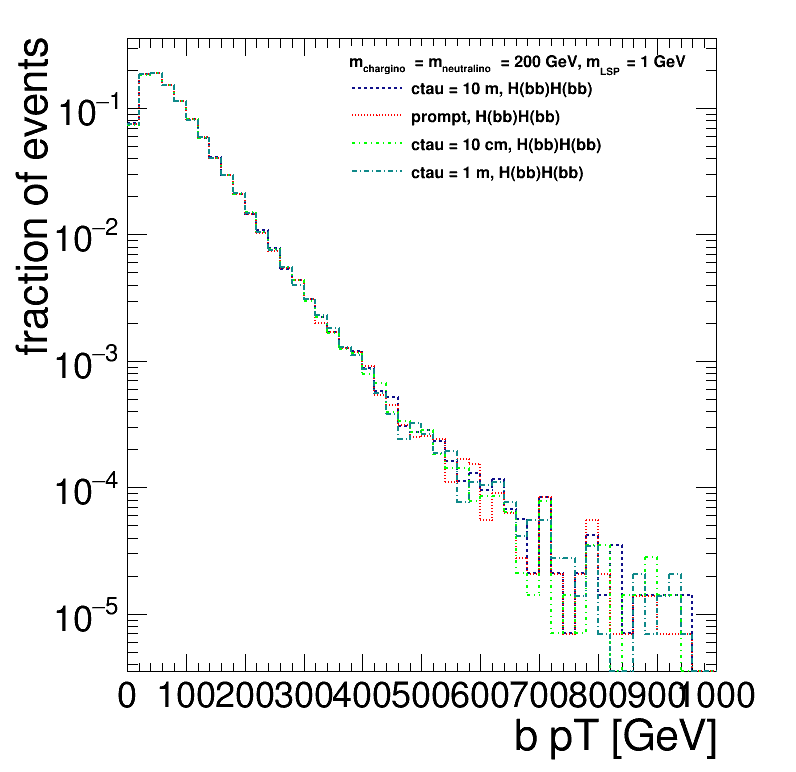

In [13]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'ev' in k:
    
        pid = v['gParticleId'].array()
        status = v['gParticleStatus'].array()
        pt = v['gParticlePt'].array()

        basic_str = np.logical_and(pid==5, status==23)

        b_pt = pt[basic_str]

        b_pt_all = b_pt.flatten()

        ht[k] = create_TH1D( b_pt_all, axis_title=['b pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        ht[k].SetLineStyle(i+2)
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'b_pt.png')

ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7fd370c0dbe0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7fd3423c1ef0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7fd315bf15c0>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fd315bf1630>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7fd2e1ef2048>


Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/bbar_pt.png has been created


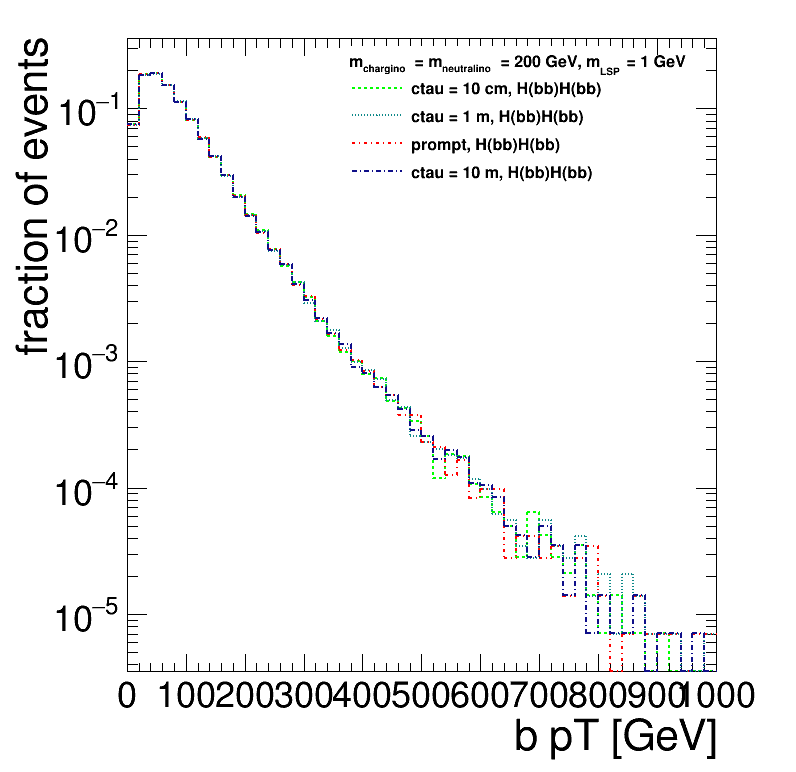

In [3]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'ev' in k:
    
        pid = v['gParticleId'].array()
        status = v['gParticleStatus'].array()
        pt = v['gParticlePt'].array()

        basic_str = np.logical_and(pid==-5, status==23)

        b_pt = pt[basic_str]

        b_pt_all = b_pt.flatten()

        ht[k] = create_TH1D( b_pt_all, axis_title=['b pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        ht[k].SetLineStyle(i+2)
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'bbar_pt.png')

# MET

2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fbdd7b099e8>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7fbdd3ae4860>
<class 'numpy.ndarray'>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7fbda73142b0>
<class 'numpy.ndarray'>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7fbda6f10ac8>
<class 'numpy.ndarray'>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7fbd2b3c2710>
<class 'numpy.ndarray'>


Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/met.png has been created


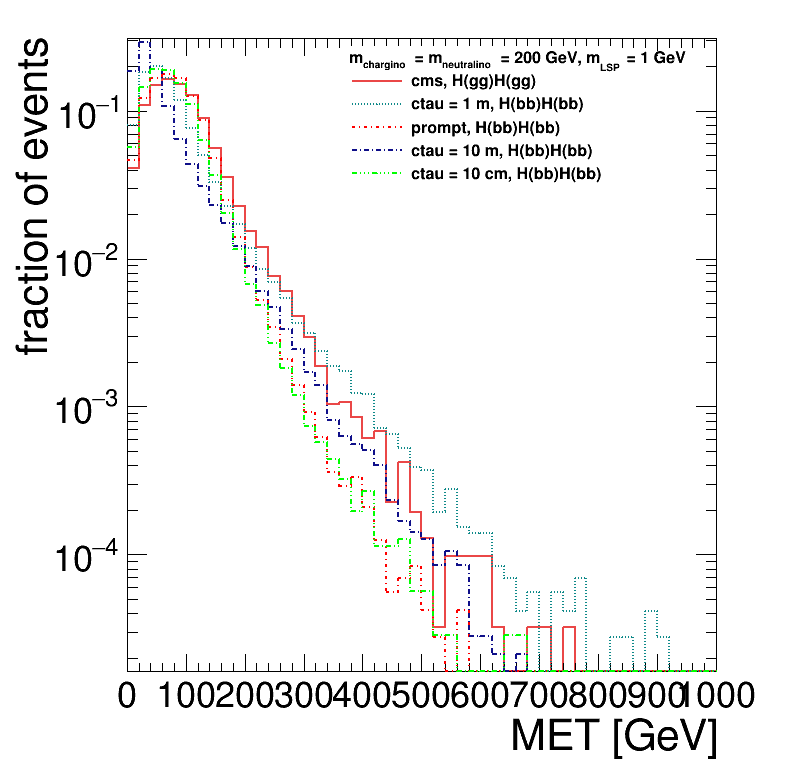

In [3]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'ev' in k:
        met = v['pfMetPt'].array()
        
        print(type(met))

#         met_all = met.flatten()


        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
    elif 'TChi' in k:
        met = v['MET'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met.png')

# Higgs Pt

In [15]:
def find_index(array1, array2):
#     print('abcde')
    out_list = []
    for i, (x,y) in enumerate(zip(array1,array2)):
#         print(i,x,y)
        out = []
        for j, (x1,y1) in enumerate(zip(x,y)):
#             print(j,x1,y1)
#             if i==0 and j==0 :
#                 print('find :',x[y1])
            out.append(x[y1])
        out = np.array(out)
        out_list.append(out)
#         if i>2:
#             break
    return out_list

2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fbdd7b099e8>
1
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7fbdd3ae4860>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
2
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7fbda73142b0>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
3
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7fbda6f10ac8>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
4
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7fbd2b3c2710>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/h_pt.png has been created


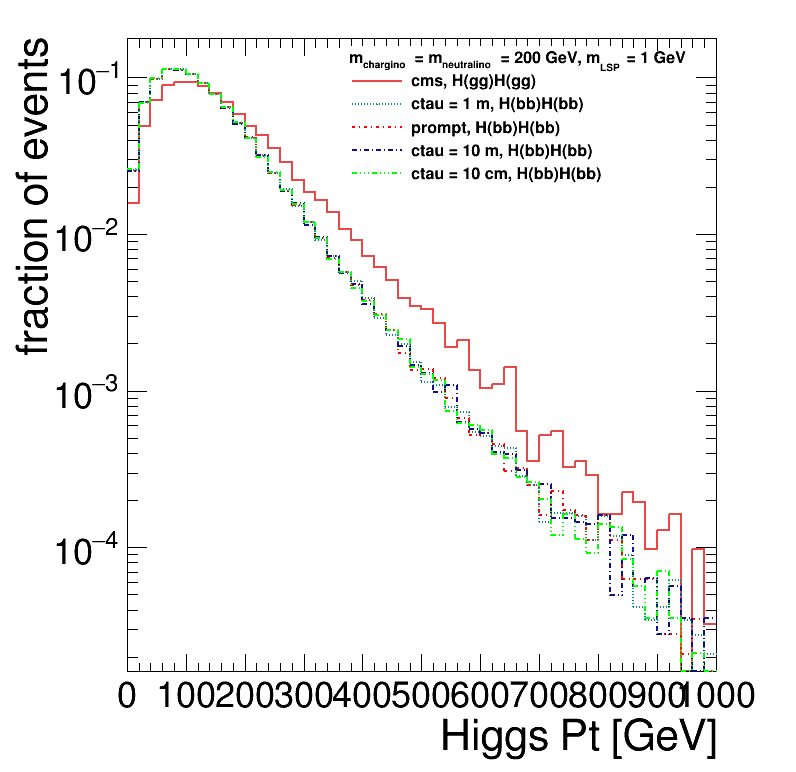

In [4]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}
out_h_save = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'ev' in k:
#     if 'prompt' in k:
        mid = v['gParticleMotherId'].array()
        mindex = v['gParticleMotherIndex'].array()
        pid = v['gParticleId'].array()
        status = v['gParticleStatus'].array()
        pt = v['gParticlePt'].array()

        basic_str = np.logical_and(pid==5, status==23)
 
        print(type(basic_str))
        print(type(basic_str[0]))
        print(basic_str[0][0])
        
        if basic_str[0][0]:
            print('yes')
        else:
            print('no')
            
#         #find pt of mother
#         mpt = find_index(pt, mid) 
    
        #get higgs pt 
#         out_h_pt = []
        out_h_pt_flat = []
        for index1, (value1, value2) in enumerate(zip(pt,mindex)):
#             out_h_pt_1 = []
            for index2, (value3, value4) in enumerate(zip(value1, value2)):
#                 print(index2)
            
                if basic_str[index1][index2]:
                    index = mindex[index1][index2]
                    value = pt[index1][index]
                    out_h_pt_flat.append(value)
 
        

 
        out_h_save[k] = out_h_pt_flat
#         print(k, out_h_save[k][0])


        h[k] = create_TH1D( out_h_pt_flat, axis_title=['Higgs Pt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
        print(i)

#     if 'TChi' in k:
    elif 'TChi' in k:
        hpt = v['HPt'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( hpt, axis_title=['Higgs Pt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
        print(i)
    

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'h_pt.png')

# Dijet mass


ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7f7da3ff4b70>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
1
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7f7da3ff4c18>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
2
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f7d26e28f98>
3
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7f7d26e68358>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
4
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7f7cf8c1ed68>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/h_mass.png has been created


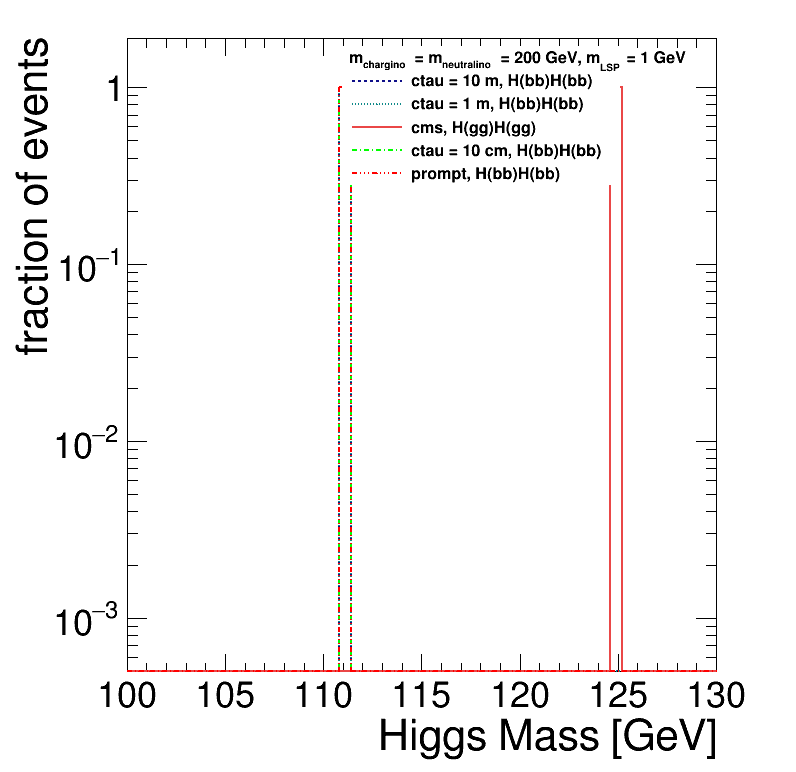

In [4]:
#SetPtEtaPhiE(pt,eta,phi,e)
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}
out_h_save = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'ev' in k:
#     if 'prompt' in k:
        mid = v['gParticleMotherId'].array()
        mindex = v['gParticleMotherIndex'].array()
        pid = v['gParticleId'].array()
        status = v['gParticleStatus'].array()
        
        pt = v['gParticlePt'].array()
        eta = v['gParticleEta'].array()
        phi = v['gParticlePhi'].array()
        e = v['gParticleE'].array()

        basic_str = np.logical_and(pid==5, status==23)
 
        print(type(basic_str))
        print(type(basic_str[0]))
        print(basic_str[0][0])
        
        if basic_str[0][0]:
            print('yes')
        else:
            print('no')
            
#         #find pt of mother
#         mpt = find_index(pt, mid) 
    
        #get higgs pt 
#         out_h_pt = []
        out_h_mass_flat = []
        for index1, (value1, value2) in enumerate(zip(pt,mindex)):
#             out_h_pt_1 = []
            for index2, (value3, value4) in enumerate(zip(value1, value2)):
#                 print(index2)
            
                if basic_str[index1][index2]:
                    index = mindex[index1][index2]
                
                    pt_value = pt[index1][index]
                    eta_value = eta[index1][index]
                    phi_value = phi[index1][index]
                    e_value = e[index1][index]
                    
                    
                    tmp_p4_h    = rt.TLorentzVector()
                    tmp_p4_h.SetPtEtaPhiE(pt_value, eta_value, phi_value, e_value)
                    
                    mass_value = tmp_p4_h.M()
                     
                    out_h_mass_flat.append(mass_value)
        

 
        out_h_save[k] = out_h_mass_flat
#         print(k, out_h_save[k][0])


        h[k] = create_TH1D( out_h_mass_flat, axis_title=['Higgs Mass [GeV]', 'fraction of events'], name="", binning=[50,100,130])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
        print(i)

#     if 'TChi' in k:
    elif 'TChi' in k:
        hpt = v['HMass'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( hpt, axis_title=['Higgs Mass [GeV]', 'fraction of events'], name="", binning=[50,100,130])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
        print(i)
    

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'h_mass.png')

# gen_time

ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7f20fad85278>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7f2064731ba8>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7f21676104e0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7f21675be0f0>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f21632b6fd0>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/gen_time.png has been created


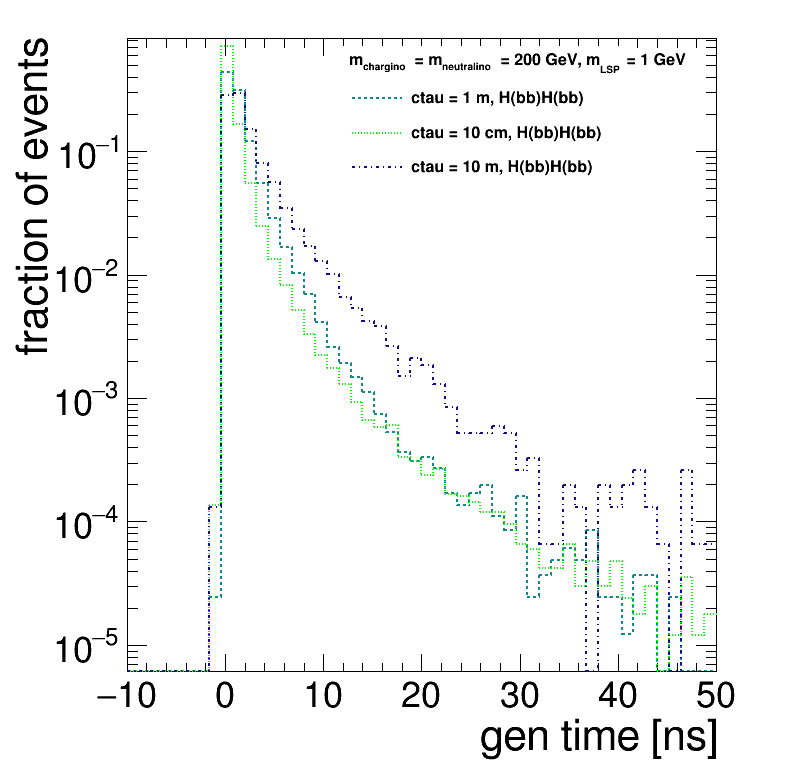

In [45]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

#     'ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root',
#     'ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root',
#     'ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root',
#     'ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root',


for k,v in tree.items(): 
    print(k,v)
    
    if 'mh200' in k:
#     if 'pl1000_' in k:
    
        t = v['gen_time'].array()
 

        t_all = t.flatten()
    
#         print(t_all[0:100])

        ht[k] = create_TH1D( t_all, axis_title=['gen time [ns]', 'fraction of events'], name="", binning=[50,-10,50])
        ht[k].SetLineStyle(i+2)
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])

#         ht[k].Draw('same')
        ht[k].DrawNormalized('same')
        ht[k].SetMinimum(0)
        ht[k].SetMaximum(1e+5)

        leg.AddEntry(ht[k], texs[k])
 
        i += 1
    

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'gen_time.png')

# lifetime

ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7f10e53e2c18>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
1
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7f10c5836f98>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
2
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7f1062883cc0>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
3
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f1062efbfd0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7f10191f7a20>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
4


Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/h_px.png has been created


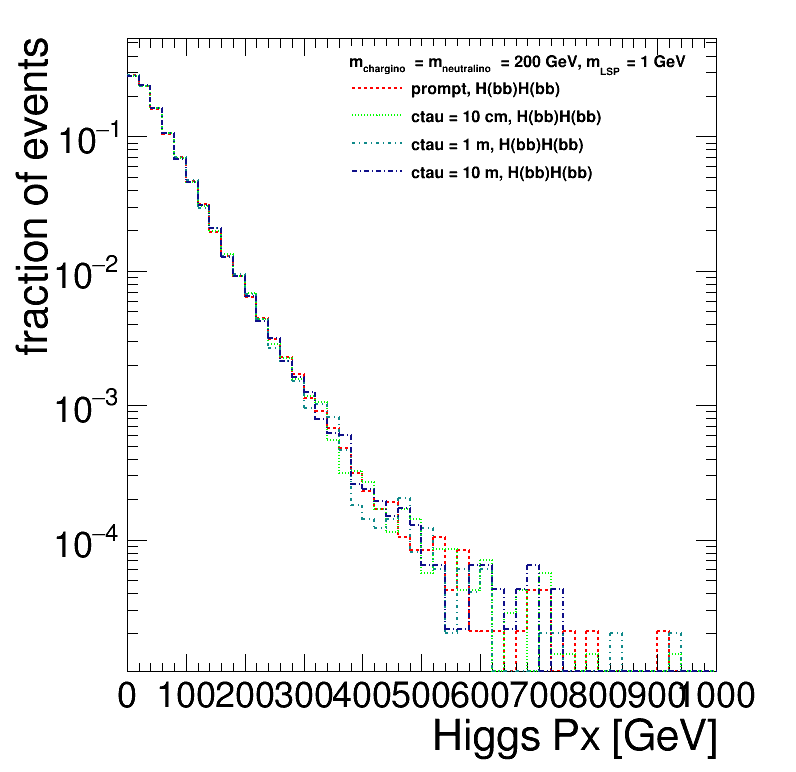

In [3]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}
out_hpt_save = {}
out_hpx_save = {}
out_hpy_save = {}
out_hpz_save = {}
out_he_save = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'aod' in k:
#     if 'prompt' in k:
        mid = v['gParticleMotherId'].array()
        mindex = v['gParticleMotherIndex'].array()
        pid = v['gParticleId'].array()
        status = v['gParticleStatus'].array()
        pt = v['gParticlePt'].array()
        px = v['gParticlePx'].array()
        py = v['gParticlePy'].array()
        pz = v['gParticlePz'].array()
        e = v['gParticleE'].array()

        basic_str = np.logical_and(pid==5, status==23)
 
        print(type(basic_str))
        print(type(basic_str[0]))
        print(basic_str[0][0])
        
        if basic_str[0][0]:
            print('yes')
        else:
            print('no')
            
#         #find pt of mother
#         mpt = find_index(pt, mid) 
    
        #get higgs info 
        out_h_pt_flat = []
        out_h_px_flat = []
        out_h_py_flat = []
        out_h_pz_flat = []
        out_h_e_flat = []
        for index1, (value1, value2) in enumerate(zip(pt,mindex)):
            for index2, (value3, value4) in enumerate(zip(value1, value2)):
                if basic_str[index1][index2]:
                    index = mindex[index1][index2]
                    value = pt[index1][index]
                    out_h_pt_flat.append(value)
                    out_h_px_flat.append(px[index1][index2])
                    out_h_py_flat.append(py[index1][index2])
                    out_h_pz_flat.append(pz[index1][index2])
                    out_h_e_flat.append(e[index1][index2])
 
 
        out_hpt_save[k] = out_h_pt_flat
        out_hpx_save[k] = out_h_px_flat
        out_hpy_save[k] = out_h_py_flat
        out_hpz_save[k] = out_h_pz_flat
        out_he_save[k] = out_h_e_flat


        h[k] = create_TH1D( out_h_px_flat, axis_title=['Higgs Px [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
        print(i)

 
    

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'h_px.png')

# ctau

2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f953fb0a8d0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7f953bad5780>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7f94f66eacc0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7f9493866390>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7f9473c01710>
 FCN=98.4678 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=3.61015e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     8.45543e+00   6.53757e-03   2.25788e-05  -2.26887e-03
   2  Slope       -1.00983e-03   4.65769e-06   1.60859e-08   3.0634

Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/decay_ctau_beta.png has been created


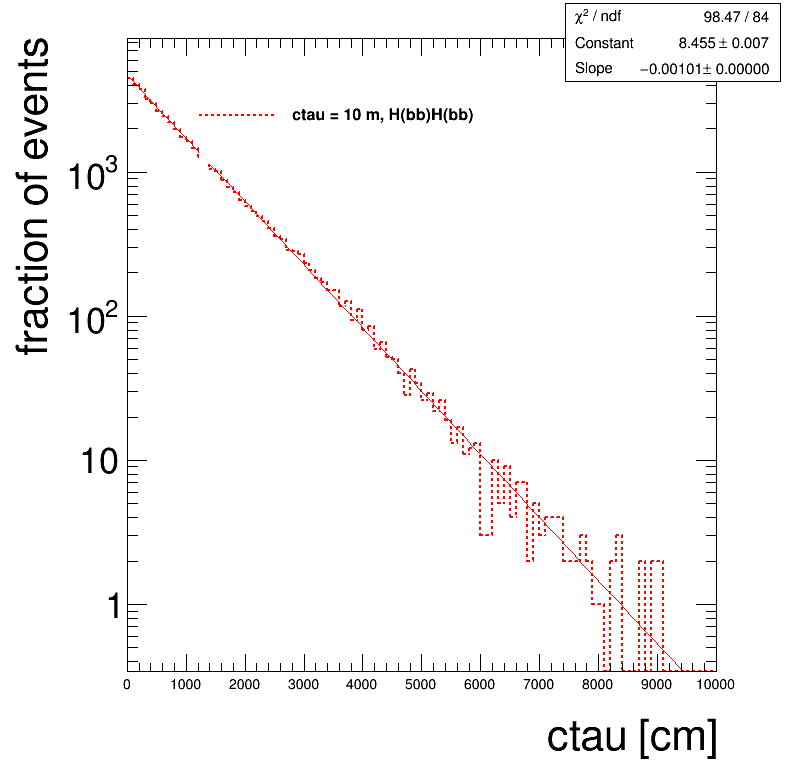

In [3]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.23,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}
hy = {}
hz = {}
hct = {}

 

for k,v in tree.items(): 
    print(k,v)
    
 
 
    if 'pl10000_' in k:
    
 
        
        beta = v['gLLP_beta'].array()
 
        decay_x = v['gLLP_decay_vertex_x'].array()
        decay_y = v['gLLP_decay_vertex_y'].array()
        decay_z = v['gLLP_decay_vertex_z'].array()

#         h_x_all = decay_x.flatten()
#         h_y_all = decay_y.flatten()
#         h_z_all = decay_z.flatten()
        
#         h_beta_all = beta.flatten()
        h_x_all = decay_x[:,0]
        h_y_all = decay_y[:,0]
        h_z_all = decay_z[:,0]
        
        h_beta_all = beta[:,0]

        h_r_all = [rt.TMath.Sqrt(pow(x,2)+pow(y,2)) for x,y in zip(h_x_all, h_y_all)]
        h_d_all = [rt.TMath.Sqrt(pow(x,2)+pow(y,2)) for x,y in zip(h_r_all, h_z_all)]
        
        out_h_ct_flat = [x/y*(rt.TMath.Sqrt(1-pow(y ,2))) for x,y in zip(h_d_all, h_beta_all)]
        
    

        hct[k] = create_TH1D( out_h_ct_flat, axis_title=['ctau [cm]', 'fraction of events'], name="", binning=[100,-0,10000])
        hct[k].SetLineStyle(i+2)
        hct[k].SetLineColor(i+2)
#         hct[k].SetMarkerColor(cols[k])
        hct[k].GetXaxis().SetLabelSize(0.02)

        hct[k].Draw('same')
#         hct[k].DrawNormalized('same')
        hct[k].Fit('expo')
#         hct[k].Fit('expo','','',10,20000)
 

      

        leg.AddEntry(hct[k], texs[k])
        
 
 
        i += 1
    

# leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
# c.SetLogx()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'decay_ctau_beta.png')

2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f953fb0a8d0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7f953bad5780>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7f94f66eacc0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7f9493866390>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7f9473c01710>
 FCN=122.843 FROM MIGRAD    STATUS=CONVERGED      47 CALLS          48 TOTAL
                     EDM=1.29347e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     8.49930e+00   6.36750e-03   2.44794e-05   2.85039e-02
   2  Slope       -9.96115e-03   4.48543e-05   1.72408e-07   5.0190

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/decay_ctau_beta_1m.png has been created


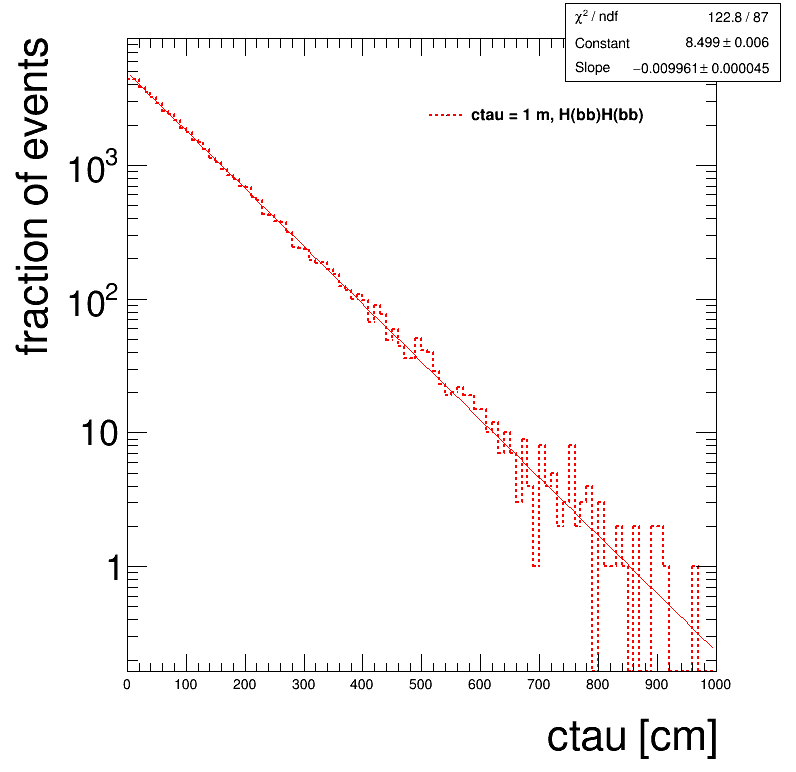

In [6]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.53,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}
hy = {}
hz = {}
hct = {}

 

for k,v in tree.items(): 
    print(k,v)
    
 
 
    if 'pl1000_' in k:
    
 
        
        beta = v['gLLP_beta'].array()
 
        decay_x = v['gLLP_decay_vertex_x'].array()
        decay_y = v['gLLP_decay_vertex_y'].array()
        decay_z = v['gLLP_decay_vertex_z'].array()

#         h_x_all = decay_x.flatten()
#         h_y_all = decay_y.flatten()
#         h_z_all = decay_z.flatten()
        
#         h_beta_all = beta.flatten()
        h_x_all = decay_x[:,0]
        h_y_all = decay_y[:,0]
        h_z_all = decay_z[:,0]
        
        h_beta_all = beta[:,0]

        h_r_all = [rt.TMath.Sqrt(pow(x,2)+pow(y,2)) for x,y in zip(h_x_all, h_y_all)]
        h_d_all = [rt.TMath.Sqrt(pow(x,2)+pow(y,2)) for x,y in zip(h_r_all, h_z_all)]
        
        out_h_ct_flat = [x/y*(rt.TMath.Sqrt(1-pow(y ,2))) for x,y in zip(h_d_all, h_beta_all)]
        
    

        hct[k] = create_TH1D( out_h_ct_flat, axis_title=['ctau [cm]', 'fraction of events'], name="", binning=[100,-0,1000])
        hct[k].SetLineStyle(i+2)
        hct[k].SetLineColor(i+2)
#         hct[k].SetMarkerColor(cols[k])
        hct[k].GetXaxis().SetLabelSize(0.02)

        hct[k].Draw('same')
#         hct[k].DrawNormalized('same')
        hct[k].Fit('expo')
#         hct[k].Fit('expo','','',10,20000)
 

      

        leg.AddEntry(hct[k], texs[k])
        
 
 
        i += 1
    

# leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
# c.SetLogx()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'decay_ctau_beta_1m.png')

2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f953fb0a8d0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_signal_aod.root <TTree b'llp' at 0x7f953bad5780>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl100_ev100000_signal_aod.root <TTree b'llp' at 0x7f94f66eacc0>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_m200_prompt_ev100000_signal_aod.root <TTree b'llp' at 0x7f9493866390>
ntuple_RunIISummer16_n3n2-n1-hbb-hbb_mh200_pl10000_ev100000_signal_aod.root <TTree b'llp' at 0x7f9473c01710>
 FCN=2762.55 FROM MIGRAD    STATUS=CONVERGED      61 CALLS          62 TOTAL
                     EDM=2.39528e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     8.71083e+00   5.01639e-03   9.83756e-05   4.97677e-03
   2  Slope       -8.90802e-02   2.88572e-04   5.65872e-06   9.3025

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190916/decay_ctau_beta_10cm.png has been created


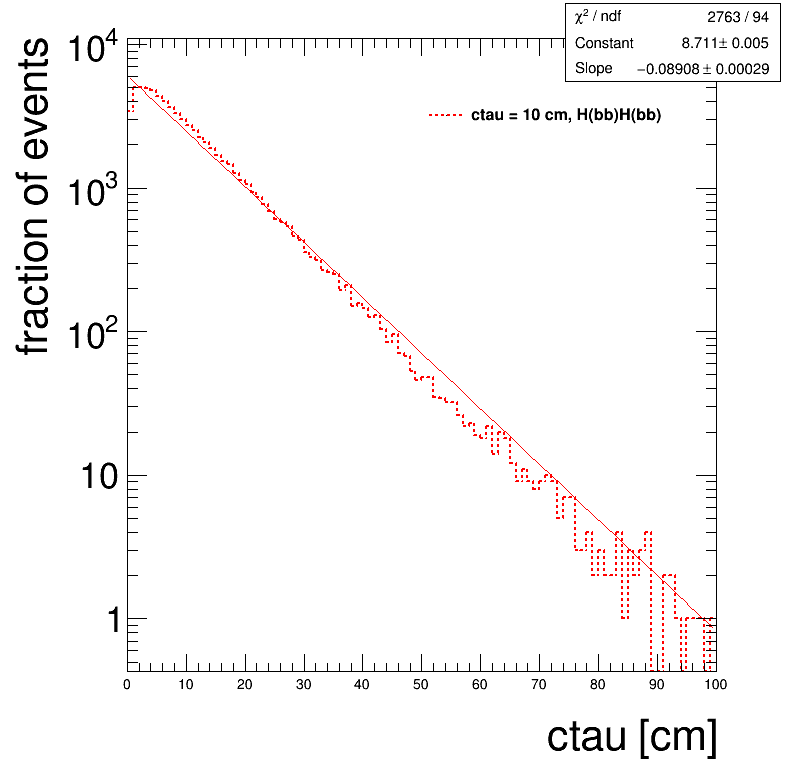

In [8]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.53,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}
hy = {}
hz = {}
hct = {}

 

for k,v in tree.items(): 
    print(k,v)
    
 
 
    if 'pl100_' in k:
    
 
        
        beta = v['gLLP_beta'].array()
 
        decay_x = v['gLLP_decay_vertex_x'].array()
        decay_y = v['gLLP_decay_vertex_y'].array()
        decay_z = v['gLLP_decay_vertex_z'].array()

#         h_x_all = decay_x.flatten()
#         h_y_all = decay_y.flatten()
#         h_z_all = decay_z.flatten()
        
#         h_beta_all = beta.flatten()
        h_x_all = decay_x[:,0]
        h_y_all = decay_y[:,0]
        h_z_all = decay_z[:,0]
        
        h_beta_all = beta[:,0]

        h_r_all = [rt.TMath.Sqrt(pow(x,2)+pow(y,2)) for x,y in zip(h_x_all, h_y_all)]
        h_d_all = [rt.TMath.Sqrt(pow(x,2)+pow(y,2)) for x,y in zip(h_r_all, h_z_all)]
        
        out_h_ct_flat = [x/y*(rt.TMath.Sqrt(1-pow(y ,2))) for x,y in zip(h_d_all, h_beta_all)]
        
    

        hct[k] = create_TH1D( out_h_ct_flat, axis_title=['ctau [cm]', 'fraction of events'], name="", binning=[100,-0,100])
        hct[k].SetLineStyle(i+2)
        hct[k].SetLineColor(i+2)
#         hct[k].SetMarkerColor(cols[k])
        hct[k].GetXaxis().SetLabelSize(0.02)

        hct[k].Draw('same')
#         hct[k].DrawNormalized('same')
        hct[k].Fit('expo')
#         hct[k].Fit('expo','','',10,20000)
 

      

        leg.AddEntry(hct[k], texs[k])
        
 
 
        i += 1
    

# leg.SetHeader('m_{chargino} = m_{neutralino} = 127 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
# c.SetLogx()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'decay_ctau_beta_10cm.png')